In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

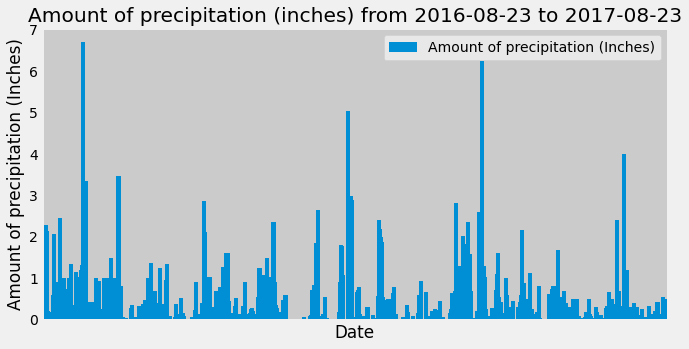

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df = pd.DataFrame(results, columns=['date', 'precipitation']).set_index('date')
# Sort the dataframe by date
last_year_df = last_year_df.sort_values(by=['date'])
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_plot = last_year_df.plot(kind="bar", figsize=(10, 5), width=15)
precipitation_plot.legend(["Amount of precipitation (Inches)"])
precipitation_plot.set_xlabel("Date")
precipitation_plot.set_ylabel("Amount of precipitation (Inches)")
precipitation_plot.set_title(f"Amount of precipitation (inches) from {year_ago} to 2017-08-23")
plt.tick_params(labelbottom=False)
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9,)]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.id)).\
group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),
            func.max(Measurement.tobs),
            func.avg(Measurement.tobs))\
            .filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

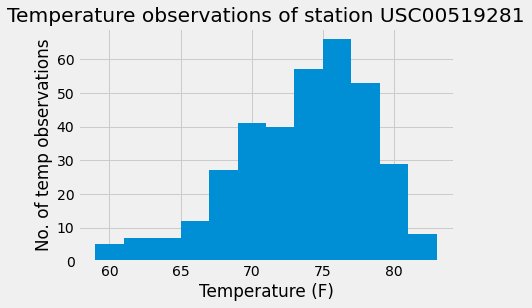

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_temp = session.query(Measurement.station, Measurement.tobs)\
    .filter(Measurement.date >= year_ago)\
    .filter(Measurement.station == 'USC00519281')\
    .all()
max_temp_df = pd.DataFrame(max_temp)

max_temp_df.plot.hist(bins=12, legend=False)
plt.xlabel("Temperature (F)")
plt.ylabel("No. of temp observations")
plt.title("Temperature observations of station USC00519281")
plt.show()

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = dt.date(2017, 1 ,1)
trip_end_date = dt.date(2017, 1 ,7)
temps_list = calc_temps(trip_start_date, trip_end_date)
temps_list

[(62.0, 68.36585365853658, 74.0)]

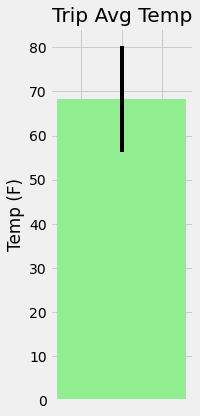

In [35]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=(3,6))
x_pos = [1]
avg_temp = [x[1] for x in temps_list]
max_temp =  [x[2] for x in temps_list]
min_temp = [x[0] for x in temps_list]
error = max_temp[0] - min_temp[0]
ax.bar(x_pos, avg_temp, yerr=[error], color='lightgreen')
ax.set_ylabel('Temp (F)')
plt.tick_params(axis='x', labelbottom=False)
ax.set_title('Trip Avg Temp')
plt.tight_layout()
plt.show()

In [36]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
total_rainfall_per_weather_station = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= trip_start_date).\
    filter(Measurement.date <= trip_end_date).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
    
rainfall_df = pd.DataFrame(total_rainfall_per_weather_station, columns=["Station", "Name", "Latitude", "Longitude", "Elevation", "Sum/Total Precipitation"])

rainfall_df

,Station,Name,Latitude,Longitude,Elevation,Sum/Total Precipitation
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.61
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.60
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.60
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.35
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.20
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00


In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start = dt.datetime.strftime(trip_start_date, "%m-%d")
end = dt.datetime.strftime(trip_end_date, "%m-%d")
start = dt.datetime.strptime(start, "%m-%d")
end = dt.datetime.strptime(end, "%m-%d")
# Use the start and end date to create a range of dates
date_array = (start + dt.timedelta(days=x) for x in range(0, ((end-start).days) + 1))
# Strip off the year and save a list of %m-%d strings
string_date_list = []
for date_object in date_array:
    string_date = date_object.strftime("%m-%d")
    string_date_list.append(string_date)
# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals_list = []
for date in string_date_list:
    daily_normals_list.append(daily_normals(date))

min_temp_list = []
avg_temp_list = []
max_temp_list = []
print(daily_normals_list)
for daily_normals_item in daily_normals_list:
    for min_temp, avg_temp, max_temp in daily_normals_item:
        min_temp_list.append(min_temp)
        avg_temp_list.append(avg_temp)
        max_temp_list.append(max_temp)

[[(62.0, 69.15384615384616, 77.0)], [(60.0, 69.39622641509433, 77.0)], [(62.0, 68.9090909090909, 77.0)], [(58.0, 70.0, 76.0)], [(56.0, 67.96428571428571, 76.0)], [(61.0, 68.96491228070175, 76.0)], [(57.0, 68.54385964912281, 76.0)]]


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame({
    "trip_dates": string_date_list,
    "tmin": min_temp_list,
    "tavg": avg_temp_list,
    "tmax": max_temp_list
})
daily_normals_df = daily_normals_df.set_index("trip_dates")
daily_normals_df

,tmin,tavg,tmax
trip_dates,,,
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0


<function matplotlib.pyplot.show(close=None, block=None)>

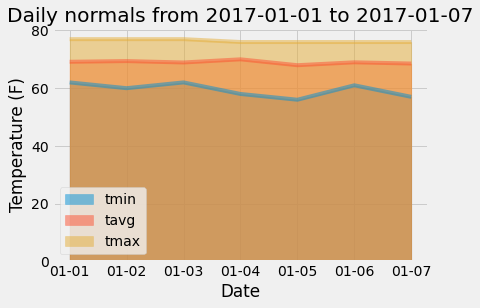

In [40]:
# Plot the daily normals as an area plot with `stacked=False`
ax = daily_normals_df.plot.area(stacked=False)
trip_start = trip_start_date.replace(year = trip_start_date.year)
trip_end = trip_end_date.replace(year = trip_end_date.year)
ax.set_title(f"Daily normals from {trip_start} to {trip_end}")
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (F)")
plt.show